
\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# 1. {-}

## 1.1 {-}

Here is what will happen if performing PCA without rescaling first. 
First note that, as shown in the below tables, in the original data there are penny stocks like 58.com as well as stock prices as high as $\$$1200, like iStar. Since large jumps in the time series are rare, iStar's closing prices from the 30 days considered will all likely be somewhat close to $\$$1200. Thus iStar's stock price time series, as a 30-dimensional data point, will be in a neighborhood of $(1200, 1200, \ldots, 1200)$. Similarly the the time series of 58.com will be in a neighborhood of $(0.4, 0.4, \ldots, 0.4)$. The same will happen to all stocks, so the original data set is merely 1000 data points, all close to a line with parametric form $t(1, 1, \ldots, 1)$. This would be the first principal component (PC) which explains almost all the variance of data. Without rescaling, this would be the only structure we find in the data. 

In the solution of 1.2 below we also show the PCA results on the original data without rescaling to confirm the above argument. 

In [1]:
import pandas as pd
from sklearn.preprocessing import Normalizer

stock_orig = pd.read_csv('stocksample.txt', sep='\t', index_col='symb')
stock_orig.min().head(), stock_orig.max().head()

(name          58.com Inc.
 2017-08-18           0.32
 2017-08-21           0.35
 2017-08-22           0.45
 2017-08-23           0.45
 dtype: object,
 name          iStar Financial Inc.
 2017-08-18                 1290.11
 2017-08-21                 1290.14
 2017-08-22                 1290.11
 2017-08-23                 1289.16
 dtype: object)

Below we remove unnecessary columns and then demean and rescale each time series to have mean 0 and variance 1. 

In [2]:
stock = stock_orig.iloc[:, 3:].T
stock = ((stock - stock.mean())/stock.std()).T

## 1.2 {-}

We define the ```pca_plots()``` function that, given the data, performs PCA on it and generates the scree plot and a plot of the first 3 principal components. We then show the results on 3 data sets: the original stock prices without rescaling, the scaled stock prices, and paths of a random walk. 


The results on the scaled stock prices show that the first PC is a momentum towards the same direction the entire month, which explains about 40% of the variance of data. Since a PC score can be negative, it is not specified if this is a upward or downward trend. The second PC is a pattern where the stock goes towards one direction in the first half of the month then comes back in the second half, which explains around 20% of the variance of data. Again, since a PC score can be negative, it is not specified in this pattern if the stock goes down in the beginning and recovers later or the other way around. In the third PC, which explains another 10% of the variance of data, we see the trend changes twice in a month. 

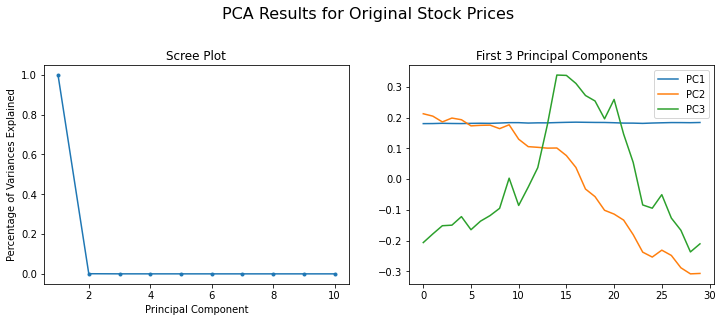

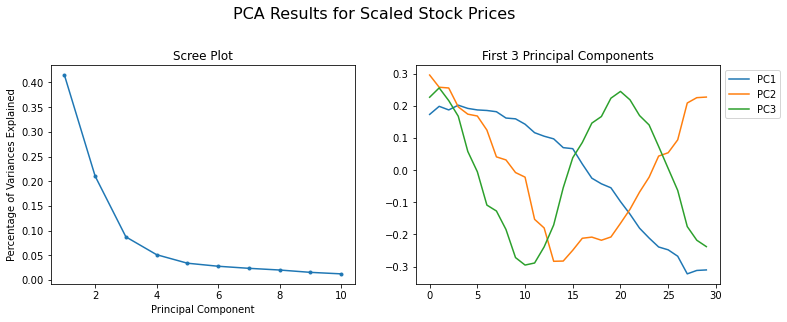

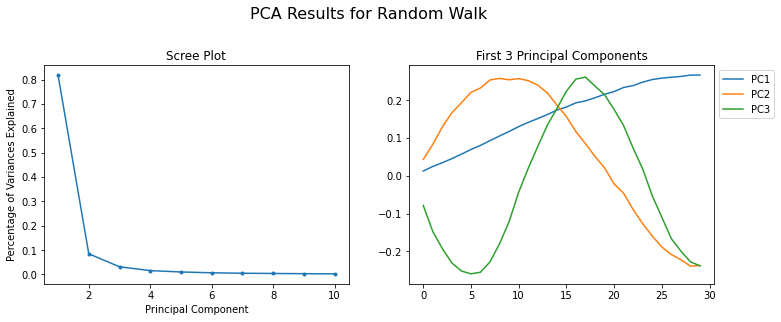

In [17]:
from scipy.stats import norm
from pandas import DataFrame, Series
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
random_walk = DataFrame([norm.rvs(size=30).cumsum() for _ in range(1000)])

def pca_plots(data, suptitle):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
    
    n_components = 10
    pcaout = PCA(n_components=n_components).fit(data)
    Series(pcaout.explained_variance_ratio_, index=range(1, n_components+1)).plot(style='.-', ax=ax[0])
    DataFrame(pcaout.components_[:3].T, columns=['PC1', 'PC2', 'PC3']).plot(ax=ax[1], legend=None)
    
    ax[0].set(title='Scree Plot', ylabel='Percentage of Variances Explained', xlabel='Principal Component')
    ax[1].set(title='First 3 Principal Components')
    
    plt.suptitle(suptitle, fontsize=16)
    plt.subplots_adjust(top=0.8)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

pca_plots(stock_orig.iloc[:, 3:], 'PCA Results for Original Stock Prices')
pca_plots(stock, 'PCA Results for Scaled Stock Prices')
pca_plots(random_walk, 'PCA Results for Random Walk')

## 1.3 {-}

Yes. With the scaled stock prices, PCA did reduce the dimensionality of the data from 30 to less than 10 important ones in the sense that the first 10 PCs together explained more than 90% of the variance of data, although it does not reveal anything useful in trading. The above PCA results on random walk paths is very similar to that of scaled stock prices. In principle, the Fourier analysis tells us *any* continuous function is a sum of sine waves with different frequencies, which are exactly what the above PCs are. The PCA results above simply says "a stock prices time series can be well approximated by a continuous function". 

# 2. {-}

Below are a scatter plot of the S curve data and the nonlinear dimension reduction results. Not surprisingly, with some noises Isomap will break, while the diffusion map still generates useful feature for color prediction (the first feature in the blow result). I have also tried to alter the magnitude of noise, which is controlled by the variable ```c``` in the below data generation. For $c = 0.5$ Isomap still generates sensible results but it starts to break as $c$ goes to 0.6 or higher, while the diffusion map seems to always generate useful features. One can observe from this experiment that the diffusion map algorithm is indeed more robust to noise. 

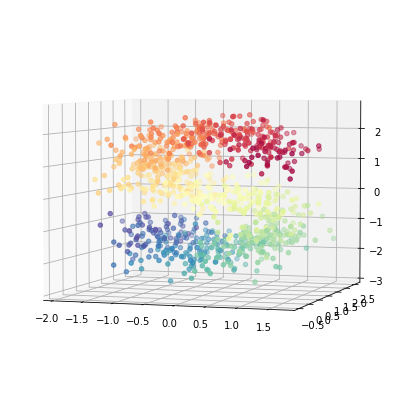

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

c = 1
n_points = 1000
Scurve, Scolor = datasets.make_s_curve(n_points, random_state=0)
noise = np.matrix(np.random.normal(0, .3, 3000)).reshape(1000,3)
Snoise = Scurve + c*noise

fig = plt.figure(figsize=(7, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Snoise[:, 0], Snoise[:, 1], Snoise[:, 2], c=Scolor, cmap=plt.cm.Spectral)
ax.view_init(4, -72)
plt.show()

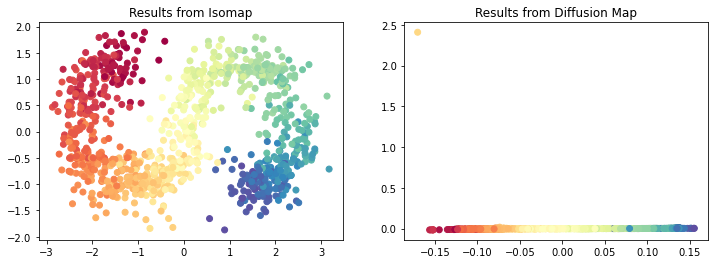

In [13]:
from pydiffmap import diffusion_map as dm
from sklearn import manifold

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

dmap = dm.DiffusionMap.from_sklearn(n_evecs=3, epsilon="bgh")
Snoisediffmap = dmap.fit_transform(Snoise)
Y = manifold.Isomap(n_neighbors=10, n_components=2).fit_transform(Snoise)

ax[0].scatter(Y[:, 0], Y[:, 1], c=Scolor, cmap=plt.cm.Spectral)
ax[0].set(title='Results from Isomap')

ax[1].scatter(Snoisediffmap[:, 0], Snoisediffmap[:, 1], c=Scolor, cmap=plt.cm.Spectral)
ax[1].set(title='Results from Diffusion Map')
plt.show()

# 3. {-}

## 3.1 {-}

From Question 1.1 we already have time series that are demeaned and rescaled to have mean 0 and variance 1.

In [3]:
stock = stock.T
stock.describe()[1:3]

symb,NEWM,DMO,VMW,CCI,MNK,CMD,MTU,XIN,INB,BOX,...,LL,RRD,OUT,VNTR,GWW,XNY,FLY,JGH,MPO,GIS
mean,4.914587e-15,-6.328271e-15,-4.141132e-15,-2.760755e-15,-2.379578e-15,-2.427688e-15,7.993606e-15,-2.146431e-15,4.124108e-14,-7.438494e-16,...,-2.164935e-15,2.442491e-15,4.500104e-15,3.922788e-16,-1.332268e-16,2.181588e-15,1.273056e-15,4.101904e-14,6.476301e-16,3.523108e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## 3.2 {-}

We compute the nonparametric smooth for each time series, with the optimal smoothing parameter found by in R. 

In [53]:
# stock = stock.iloc[:, :5]

In [6]:
stock['dateIdx'] = range(30)

In [7]:
import rpy2
%load_ext rpy2.ipython

In [8]:
%%R -i stock -o optspan

library(fANCOVA)

optspan <- list()

for (ticker in colnames(stock))
{
    holdlo = loess.as(stock$dateIdx, stock[[ticker]], criterion='aicc')
    optspan[[ticker]] <- holdlo$pars$span
}

R[write to console]: fANCOVA 0.5-1 loaded



In [9]:
stock.drop('dateIdx', axis='columns', inplace=True)

Here we want to oversmooth the series so we apply a map that makes each optimal span larger (but still less than 1 which is the largest span allowed). 

In [10]:
span = {k: 1-0.9*(1-v[0]) for k, v in optspan.items()}

We compute the nonparametric smooth. Below are a plot for the first 5 tickers. It can be seen that the trend in each time series is preserved. 

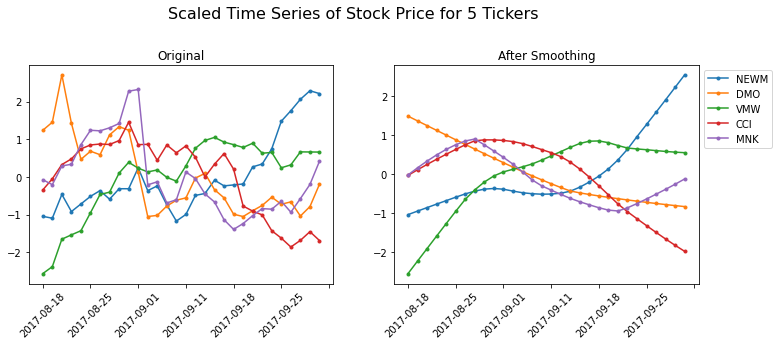

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import DataFrame

smooth = DataFrame(index=stock.index)

for ticker in stock.columns:
    lowout = sm.nonparametric.lowess(stock[ticker], range(30), frac=span[ticker])
    smooth[ticker] = lowout[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
stock.iloc[:, :5].plot(style='.-', rot=45, ax=ax[0], legend=None, title='Original')
smooth.iloc[:, :5].plot(style='.-', rot=45, ax=ax[1], legend=None, title='After Smoothing')

plt.suptitle('Scaled Time Series of Stock Price for 5 Tickers', fontsize=16)
plt.subplots_adjust(top=0.80)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
### The procedure is time consuming so we save the nonparametric smooth results locally
# smooth.T.to_csv('stocksmooth.csv')

## 3.3 {-}

Before applying Isomap we first look at PCA results. The below scree plot shows that the first 3 PCs together explains 95% of the variance of the data. This indicates that the smoothed time series can be mapped to a 3-dimensional space without losing too much information. 

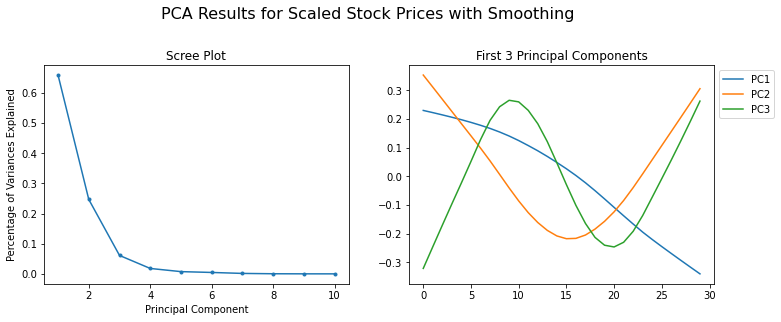

In [18]:
pca_plots(smooth, 'PCA Results for Scaled Stock Prices with Smoothing')

Below we run Isomap to map the smoothed time series to a 5-dimensional space. The recovered features are named ```iso1```, ```iso2```, ```iso3```, ```iso4``` and ```iso5```, respectively. As expected, iso1 has the most variances, followed by iso2, followed by iso3. In comparison, iso4 and iso5 have small variances and can be treated as noises. In addition, compared to other sectors, green and yellow dots seem to have larger variances in the iso3, iso4 and iso5 dimensions, and more outliers too. This indicates that even after smoothing, the corresponding sectors still have relatively more noisy time series. 

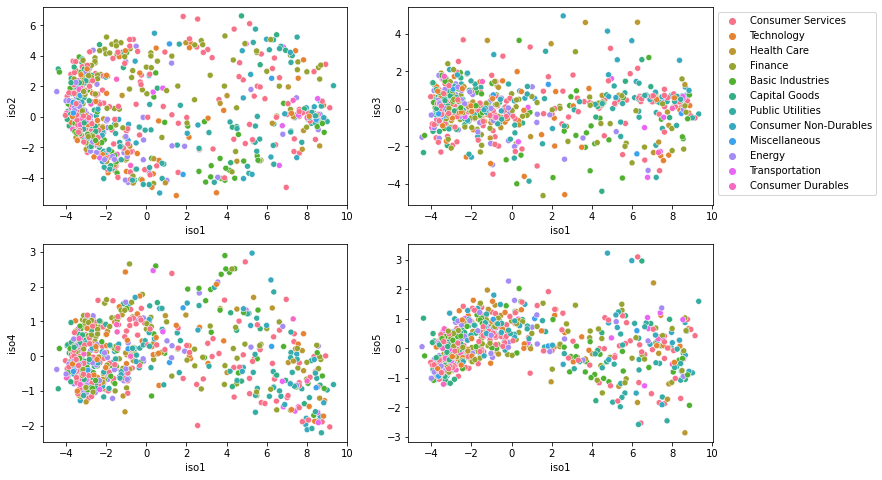

In [4]:
from pandas import DataFrame
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

stock_orig = pd.read_csv('stocksample.txt', sep='\t', index_col='symb')
smooth = pd.read_csv('stocksmooth.csv', index_col=0)
isoout = DataFrame(
    manifold.Isomap(n_neighbors=10, n_components=5).fit_transform(smooth), 
    columns=['iso1', 'iso2', 'iso3', 'iso4', 'iso5'])
isoout['sector'] = stock_orig['sector'].values

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

sns.scatterplot(x='iso1', y='iso2', data=isoout, hue='sector', ax=ax[0][0], legend=None)
sns.scatterplot(x='iso1', y='iso3', data=isoout, hue='sector', ax=ax[0][1])
sns.scatterplot(x='iso1', y='iso4', data=isoout, hue='sector', ax=ax[1][0], legend=None)
sns.scatterplot(x='iso1', y='iso5', data=isoout, hue='sector', ax=ax[1][1], legend=None)
ax[0][1].legend(bbox_to_anchor=(1, 1))
plt.show()


## 3.4 {-}

Below is a comparison of the dendrograms of the stock prices before and after smoothing. As expected, after smoothing the stocks are easier to form clusters. For example, at a height of 7, the smoothed stock prices only have 5 clusters while the stock prices without smoothing still have more than 10. If two series are close to each other before smoothing (e.g. Tekla Healthcare Opportunies Fund and Plains Group Holdings, L.P.), they will be close after smoothing, and vice versa. Smoothing is a good way to get rid of noise while preserving important information in the data. 

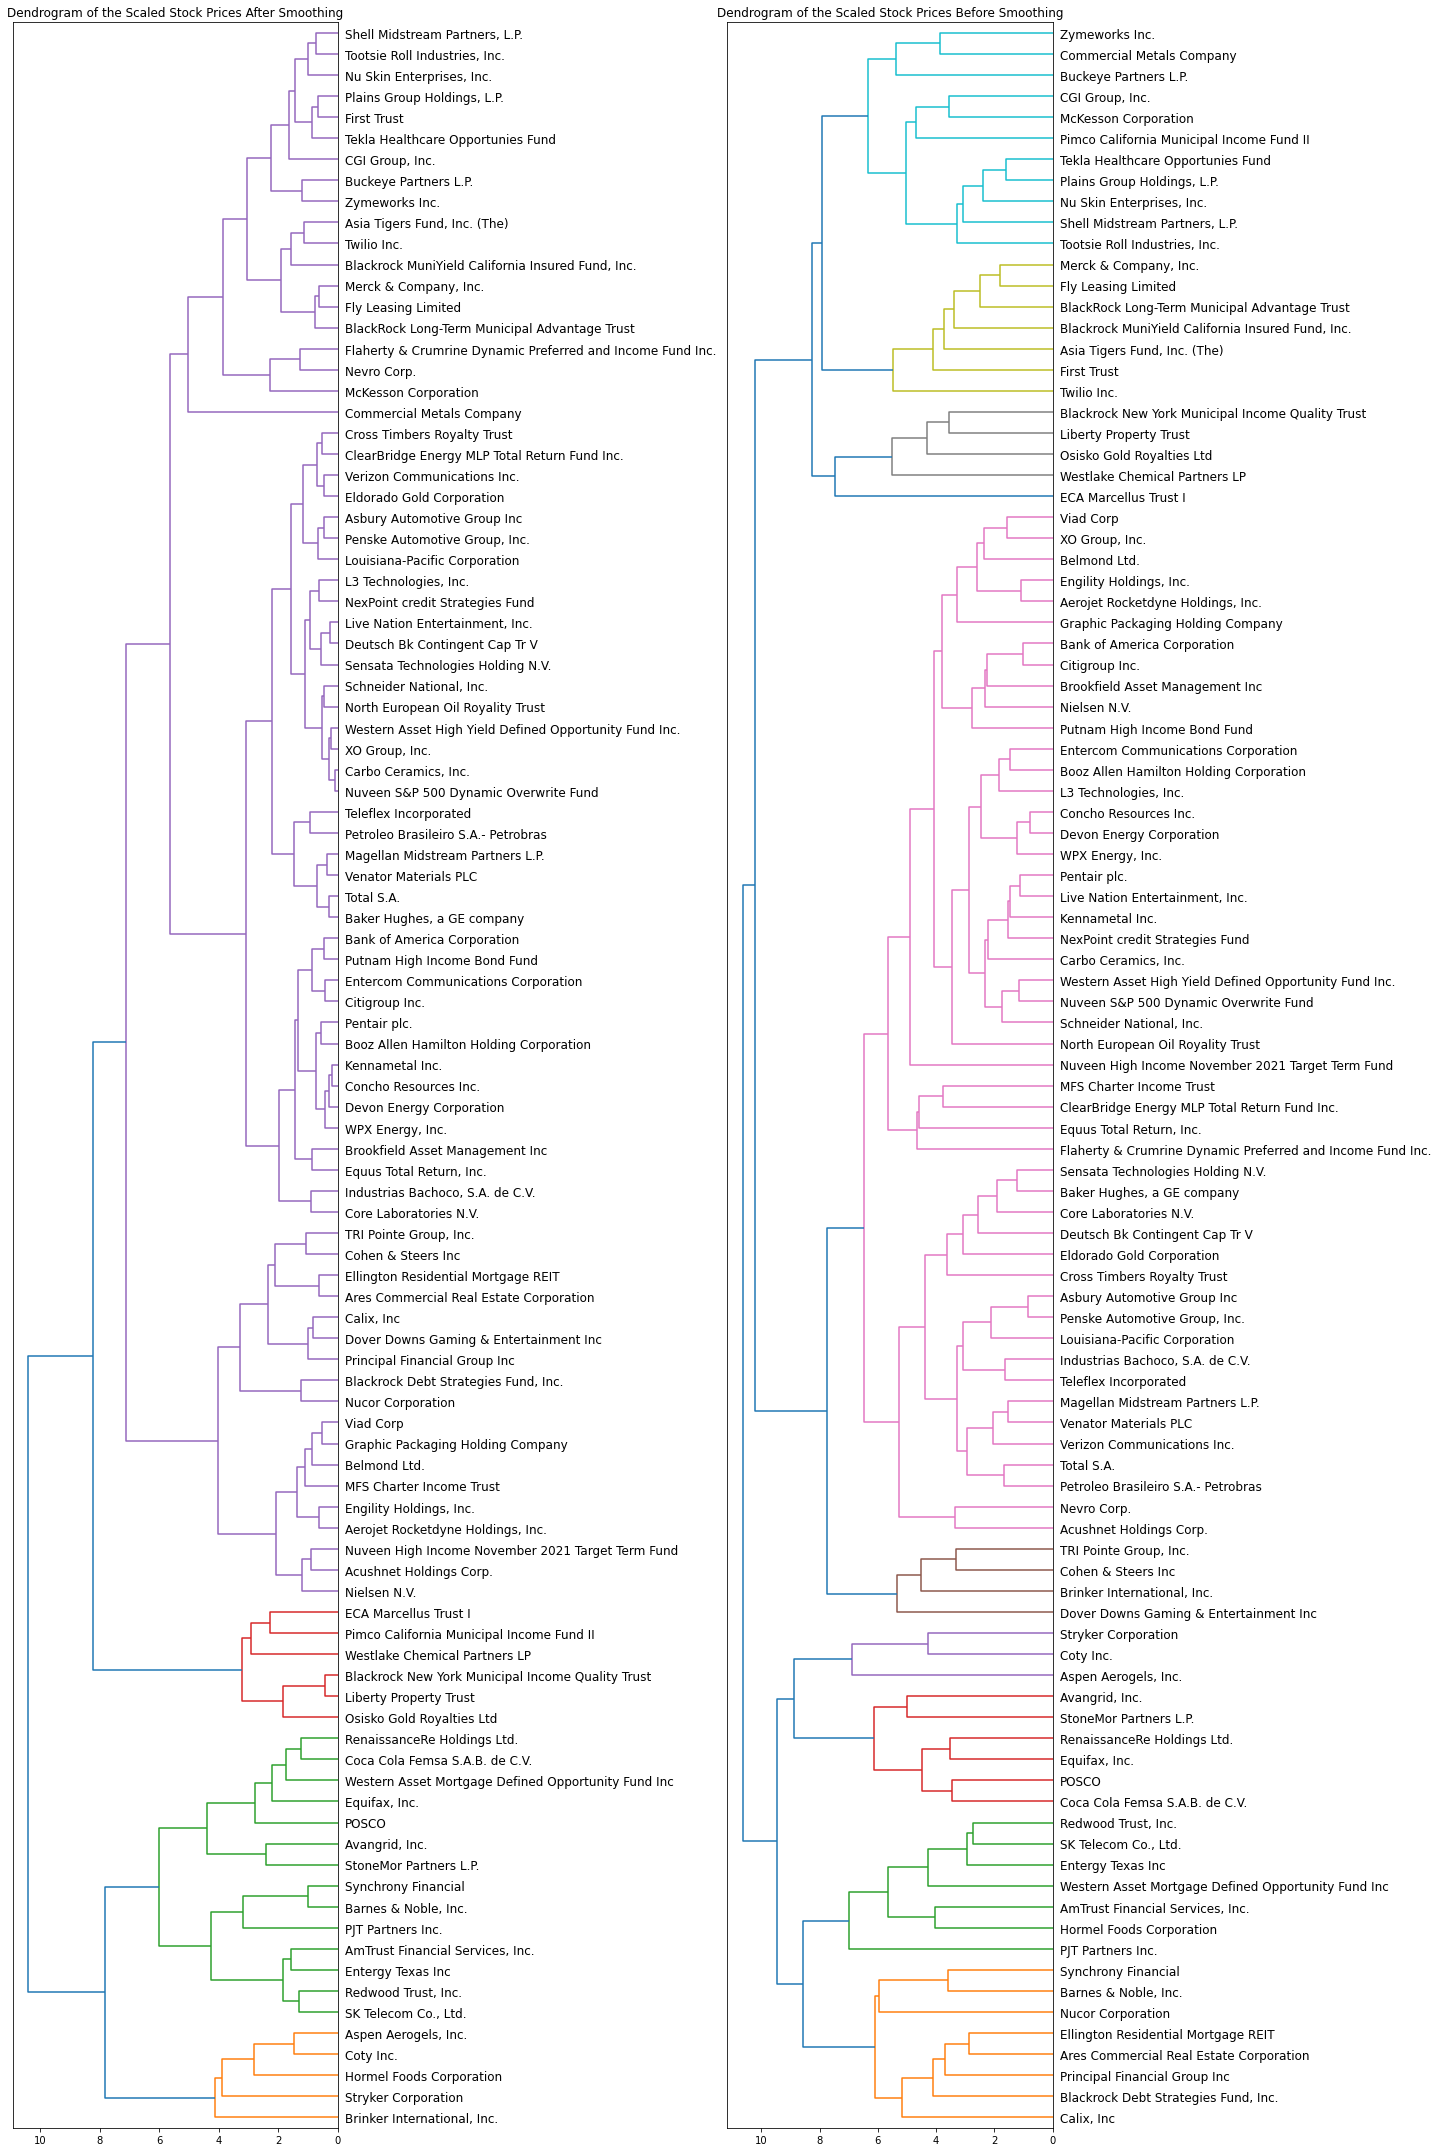

In [5]:
import numpy as np
from scipy.cluster import hierarchy

np.random.seed(0)
smooth100 = smooth.loc[np.random.choice(smooth.index, size=100, replace=False)]
hcoutsmooth = hierarchy.linkage(smooth100, method="complete")

stock100 = stock.T.loc[smooth100.index]
hcoutstock = hierarchy.linkage(stock100, method='complete')


fig, ax = plt.subplots(1, 2, figsize=[20, 30])
labs = stock_orig['name'][smooth100.index]
hierarchy.dendrogram(hcoutsmooth, ax=ax[0], orientation='left', labels=labs, leaf_font_size=12)
hierarchy.dendrogram(hcoutstock, ax=ax[1], orientation='left', labels=labs, leaf_font_size=12)

ax[0].set(title='Dendrogram of the Scaled Stock Prices After Smoothing')
ax[1].set(title='Dendrogram of the Scaled Stock Prices Before Smoothing')

plt.tight_layout()
plt.show()